### Seminar 8: Molecular simulations with machine learning potentials

Agenda

- Calculating forces and energies
- ASE calculators and optimizers
- Using universal interatomic potentials
- Thermal expansion
- Li-ion diffusion

### Note: Turn on GPU support

Runtime -> Change runtime type -> T4 GPU

### Part 1: ASE's calculators and optimizers. Fitting the Lennard-Jones pair potential example

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Graph_of_Lennard-Jones_potential.png/1920px-Graph_of_Lennard-Jones_potential.png" width=320 height=200 />


<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/82d16f77cae964a5c4c52fb89165dd5d596ee03f" width=320 height=200 />




There are calculators in ASE. These are used to calculate energies, forces, and stress tensors for a given atomic structure at the given level of theory.  

In [1]:
!pip install ase

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read, write
from ase.calculators.lj import LennardJones # importing LennardJones calculator

We will work with the argon_energies.xyz dataset. The dataset contains several structures of bulk Ar and their energies. The physical quantities are calculated with the density functional theory.

data source: https://kitchingroup.cheme.cmu.edu/blog/2017/11/19/Training-the-ASE-Lennard-Jones-potential-to-DFT-calculations/

In [49]:
!mkdir data
!wget -O./data/argon_energies.xyz https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar09/argon_energies.xyz
!wget -O "./data/Li10Ge(PS6)2_mp.cif" "https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar09/Li10Ge(PS6)2_mp.cif"

mkdir: cannot create directory ‘data’: File exists
--2025-10-20 09:40:00--  https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar09/argon_energies.xyz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29429 (29K) [text/plain]
Saving to: ‘./data/argon_energies.xyz’

./data/argon_energi 100%[===================>]  28.74K  --.-KB/s    in 0.001s  

2025-10-20 09:40:00 (35.1 MB/s) - ‘./data/argon_energies.xyz’ saved [29429/29429]

--2025-10-20 09:40:00--  https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar09/Li10Ge(PS6)2_mp.cif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.git

In [5]:
atoms_list = read('data/argon_energies.xyz', index = ':')

In [6]:
atoms = atoms_list[-1]
atoms

Atoms(symbols='Ar2', pbc=True, cell=[[0.0, 5.39, 5.39], [5.39, 0.0, 5.39], [5.39, 5.39, 0.0]])

In [7]:
# Define parameters of the potential
epsilon, sigma = .5, 5.0

# Define calculator for the atoms object
atoms.calc = LennardJones(sigma = sigma, epsilon = epsilon, rcut = 10.0, )

You can check out the LJ calculator class here: https://ase-lib.org/_modules/ase/calculators/lj.html

In [8]:
# calculate potential energy of the structure
atoms.get_potential_energy()

3.4819694565085935

In [9]:
# calculate forces acting on atoms in the structure
atoms.get_forces()

array([[-0.17251716,  0.35628568, -0.97630565],
       [ 0.17251716, -0.35628568,  0.97630565]])

There are a number of different optimizers available in ASE to optimize an objective function. In the case of crystal structure we want to minimize the forces acting on each atom.

In [10]:
from ase.optimize import BFGS

Let's optimize our crystal structure

The optimizer adjusts the atomic coordinates to minimize the forces acting on the atoms (energy of the system). Doesn't this remind you of loss minimization to find the best fit in linear regression? The weights in the case of minimizing the forces are the (x, y, z) coordinates of the atoms.

In [11]:
optim = BFGS(atoms)
optim.run(fmax = 0.001)

      Step     Time          Energy          fmax
BFGS:    0 08:57:54        3.481969        1.053506
BFGS:    1 08:57:55        3.464118        0.132667
BFGS:    2 08:57:55        3.463835        0.002711
BFGS:    3 08:57:55        3.463835        0.000085


True

In [12]:
# let's slightly disturb our structure
atoms.positions += np.random.normal(loc = 0, scale = 0.5, size = (len(atoms), 3))

In [13]:
optim = BFGS(atoms)
optim.run(fmax = 0.001)

      Step     Time          Energy          fmax
BFGS:    0 08:57:56       36.945414       63.562251
BFGS:    1 08:57:56       26.967440       64.150262
BFGS:    2 08:57:56       13.148101       31.266407
BFGS:    3 08:57:56        7.160590       13.217767
BFGS:    4 08:57:56        4.381619        7.434972
BFGS:    5 08:57:56        4.493475        9.121864
BFGS:    6 08:57:56        3.709709        3.943384
BFGS:    7 08:57:56        3.627620        3.160236
BFGS:    8 08:57:56        3.564688        2.480192
BFGS:    9 08:57:56        3.531160        2.060002
BFGS:   10 08:57:56        3.489390        1.243946
BFGS:   11 08:57:56        3.472918        0.740627
BFGS:   12 08:57:56        3.464087        0.125455
BFGS:   13 08:57:56        3.463857        0.037104
BFGS:   14 08:57:56        3.463835        0.003621
BFGS:   15 08:57:56        3.463835        0.000569


True

In [16]:
# two different polymorphs
atoms1, atoms2 = atoms_list[0], atoms_list[-1]

atoms1.calc = LennardJones(sigma = sigma, epsilon = epsilon, rcut = 10.0)
atoms2.calc = LennardJones(sigma = sigma, epsilon = epsilon, rcut = 10.0)


energy_difference = atoms1.get_potential_energy()/len(atoms2) - atoms1.get_potential_energy()/len(atoms1)
energy_difference # eV/atom

-42.068344175135316

Is this energy difference feasible? Let's compare with the density functional theory calculated energies

In [17]:
energy1 = atoms1.info['relative_total_energy']
energy2 = atoms2.info['relative_total_energy']
energy1/len(atoms1) - energy2/len(atoms2)

-0.026433055000000004

Text(0.5, 0, 'Energy')

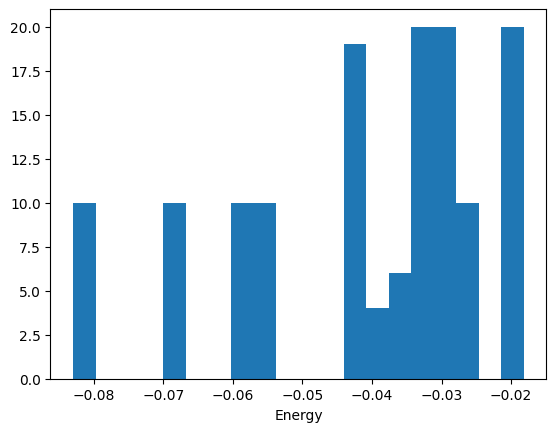

In [18]:
energies = [atoms.info['relative_total_energy'] for atoms in atoms_list]
plt.hist(energies, 20)
plt.xlabel('Energy')

In [19]:
for atoms in atoms_list:
    atoms.calc = LennardJones(sigma = sigma, epsilon = epsilon, rcut = 10.0, )
predicted_energies = [atoms.get_potential_energy() for atoms in atoms_list]

Text(0, 0.5, 'LJ')

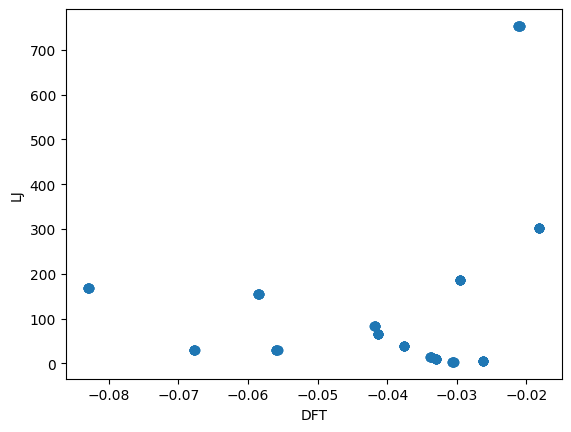

In [20]:
plt.scatter(energies, predicted_energies)
plt.xlabel('DFT')
plt.ylabel('LJ')

As you see the energies are far away from the calculated with LJ potential. This is due to the epsilon and sigma parameters. Let's find the best parameters that fits the DFT data. For this we will minimize the mean squared error of energy predictions with our LJ potential compared to the DFT data.

In [21]:
import numpy as np
from scipy.optimize import fmin
from ase.calculators.lj import LennardJones

# original code source: https://kitchingroup.cheme.cmu.edu/blog/2017/11/19/Training-the-ASE-Lennard-Jones-potential-to-DFT-calculations/

def my_lj(params):
    """
    This function returns potential energy predictions
    for a given set of LJ pair potential parameters.
    """
    global configurations
    epsilon, sigma = params

    # Ensure parameters stay positive and reasonable
    epsilon = max(epsilon, 1e-6)
    sigma = max(sigma, 1e-6)

    calc = LennardJones(sigma=sigma, epsilon=epsilon)
    predictions = []
    for atoms in configurations:
        atoms.calc = calc
        try:
            energy = atoms.get_potential_energy()
            predictions.append(energy)
        except:
            # Return large loss if calculation fails
            return np.full(len(configurations), 1e10)

    return np.array(predictions)

def loss(target, prediction):
    """
    Mean squared error loss function
    """
    return np.square(prediction - target).mean()

def callback(params):
    """
    Used to save history of the training
    """
    steps.append(params)

def objective(params):
    """
    Objective function we want to minimize
    """
    global targets
    predictions = my_lj(params)
    return loss(targets, predictions)

# Your data
configurations = atoms_list
targets = np.array([atoms.info['relative_total_energy'] for atoms in atoms_list])
steps = []

# Optimize with bounds by using a constrained method
LJ_pars = fmin(objective, x0=[0.5, 5.0], callback=callback, ftol=1e-6, disp=True)
print(LJ_pars)

Optimization terminated successfully.
         Current function value: 0.000141
         Iterations: 113
         Function evaluations: 214
[0.00592838 3.73316798]


In [24]:
loss_history = []
for step in steps: # iterate over parameters at each optimization step
    loss_history.append(loss(targets, my_lj(step)))

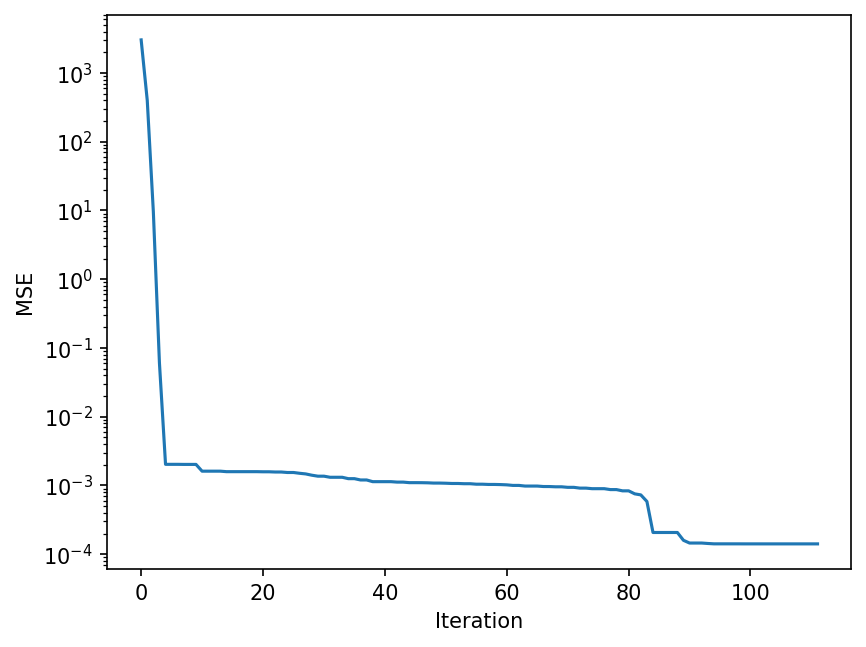

In [25]:
plt.figure(dpi = 150)
plt.plot(loss_history)
plt.ylabel('MSE')
plt.xlabel('Iteration')
plt.yscale('log')

Now we have a much better fit to the DFT data.

Text(0.5, 0, 'DFT energy')

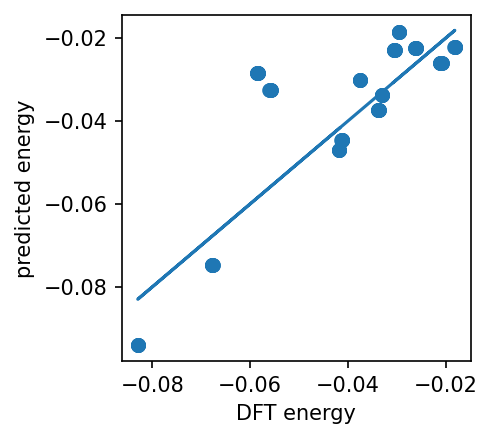

In [26]:
fig, ax = plt.subplots(dpi = 150, figsize = (3, 3))

ax.scatter(targets, my_lj(LJ_pars))
ax.plot(targets, targets)
ax.set_ylabel('predicted energy')
ax.set_xlabel('DFT energy')

- Now you have the intuition behind interatomic potential fitting.

- Today we will use the SevenNet universal interatomic potential trained on the MPtrj dataset - a dataset of crystal structure configurations from the Materials project database with calculated energies, forces, and stress tensors using density functional theory.

- In other words, someone did the same thing we did, but instead of fitting the LJ potential with two parameters to several different structures, the graph neural network with ~800K parameters (weights) was fitted to the ~1,000,000 energies, ~10,000,000 forces, and stress tensors.

- Here, the term "universal" means that this potential is intended to accurately predict energies and forces for crystal structures from a wide range of chemical systems.

The `sevennet` library provides the SevenNetCalculator compatible with the ASE library, which allows using the ASE functionality for running molecular dynamics simulations and optimizing crystal structures

In [27]:
# install SevenNet library
!pip install sevenn

In [29]:
import numpy as np
from ase.io import read, write
from ase.optimize import FIRE
from ase.md.npt import NPT
from ase.units import fs
from ase.build import make_supercell
from sevenn.sevennet_calculator import SevenNetCalculator

In [30]:
sevennet_0_cal = SevenNetCalculator("7net-0", device='cuda') # we use cuda device, i.e. GPU, for a faster calculations


In [45]:
# Li10Ge(PS6)2, LGPS for a shorter notation, is known for its fast Li-ion conductivity
atoms = read('data/Li10Ge(PS6)2_mp.cif')

P = [
    [1, 0, 0],
    [0, 2, 0],
    [0, 0, 2]
]
# create supercell for better statistics
supercell = make_supercell(atoms, P)
print(len(supercell))

200


In [32]:
# set calculator
supercell.calc = sevennet_0_cal
print(supercell.get_potential_energy())

-863.3062133789062


In [33]:
# optimize crystal structure
# FIRE is the method for optimizing an objective function.
# Newtonian dynamics with added friction https://wiki.fysik.dtu.dk/ase/ase/optimize.html
optim = FIRE(supercell)

In [34]:
optim.run(fmax = 0.01)

      Step     Time          Energy          fmax
FIRE:    0 09:11:25     -863.306213        0.079664
FIRE:    1 09:11:26     -863.311035        0.077805
FIRE:    2 09:11:26     -863.319214        0.073962
FIRE:    3 09:11:26     -863.328613        0.067916
FIRE:    4 09:11:26     -863.338501        0.059606
FIRE:    5 09:11:27     -863.349182        0.055367
FIRE:    6 09:11:27     -863.360352        0.047197
FIRE:    7 09:11:27     -863.370911        0.038270
FIRE:    8 09:11:27     -863.380310        0.031638
FIRE:    9 09:11:27     -863.388428        0.035686
FIRE:   10 09:11:27     -863.396118        0.029277
FIRE:   11 09:11:27     -863.402954        0.043747
FIRE:   12 09:11:27     -863.409668        0.052494
FIRE:   13 09:11:28     -863.418213        0.041407
FIRE:   14 09:11:28     -863.426758        0.027490
FIRE:   15 09:11:28     -863.435852        0.027884
FIRE:   16 09:11:28     -863.443420        0.031513
FIRE:   17 09:11:28     -863.449585        0.032258
FIRE:   18 09:

True

In [35]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution

In [36]:
MaxwellBoltzmannDistribution(supercell, temperature_K = 1000) # create a distribution of velocities

In [37]:
# define the ensemble and thermostat
T = 1000
thermo = NPT(supercell,
             temperature_K = T,
             timestep = 2 * fs, # convert to fs
             trajectory=f'data/md_{T}.traj',
             loginterval = 10, # save configurations with the given interval between the steps
             logfile=f'data/md_{T}.log',
             ttime = 40 * fs,
             pfactor = (75 * fs)**2 * 0.6,
             externalstress = 0,
             )

In [38]:
# run MD simulation for 10,000 steps
thermo.run(10000) # takes ~15 minutes

True

In [46]:
# if you don't want to wait
!wget -O./data/md_1000.traj https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar09/md_1000.traj

--2025-10-20 09:38:42--  https://raw.githubusercontent.com/dembart/intro-to-materials-informatics/refs/heads/main/data/seminar09/md_1000.traj
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16700804 (16M) [application/octet-stream]
Saving to: ‘./data/md_1000.traj’

./data/md_1000.traj 100%[===================>]  15.93M  --.-KB/s    in 0.06s   

2025-10-20 09:38:42 (269 MB/s) - ‘./data/md_1000.traj’ saved [16700804/16700804]



In [48]:
# read saved trajectory
traj = read('data/md_1000.traj', index = ':')

###Task 1: V vs. time
 Plot volume of the supercell vs. time. Has it converged?

<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipython-input-1042622521.py:3: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('Volume, $\AA^3$')


Text(0, 0.5, 'Volume, $\\AA^3$')

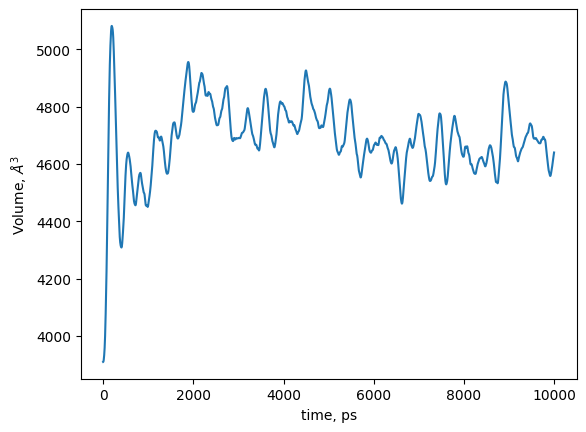

In [41]:
plt.xlabel('time, ps')
plt.ylabel('Volume, $\AA^3$')

### Task 2. MSD

Write a function that calculates the mean squared displacement at each timestep for a given atomic type.



The mean squared displacement measures the average squared distance particles travel over time:

$$MSD(\tau) = \langle |\mathbf{r}(t+\tau) - \mathbf{r}(t)|^2 \rangle$$

For normal diffusion, this follows:
$$MSD(\tau) = 2dD\tau$$, where

- $d$ - dimensionality of diffusion
- $D$ - diffusion coefficient

In [ ]:
def classical_msd(trajectory, specie):

    """
    Calclate classical mean squared displacement
    for a given specie

    Params:
    ------
    trajectory: list of ase's Atoms objects
        simulation trajectory

    specie: str
        atomic symbol
    """


    ### your code ###
    pass

### Task 3: MSD(element) vs. time

Plot MSD for each chemical element in the LGPS structure

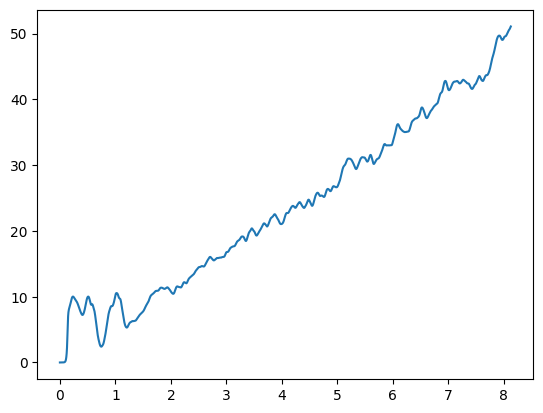

### Task 4: Slope

Fit the line to the linear region of the MSD(t) curve calculated for Li ions

In [ ]:
# your code

In [ ]:
def _diffusion_coefficient(slope, dim = 3):

    """
    slope = [A ^ 2 / ps]
    d = [cm ^ 2 / s]
    """
    d = 1 / (2 * dim) * slope * (1e-16) / (1e-12)
    return d

### Task 5. Arrhenius equation

$D = D_0\exp(-E_a/kT)$

- Run several MD simulations at different temperatures (T=600, 800, 1000)

- Fit the line to each of the MSD curves calculated for Li ion
- Calculate D(T)
- Fit the line to the log10(D) vs. 1/T
- Extract $D_0$ and $E_a$
- Compare calculated values with the literature data

literature data: https://ceder.berkeley.edu/publications/YiFei_Lithium_Conductor.pdf
